In [1]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow import keras
import matplotlib.pyplot as plot
import numpy as np
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


In [3]:
Images = np.load('./dataset/Image_224.npy') #converting the list of images to numpy array.
Labels = np.load('./dataset/Label_224.npy')

In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (16785, 224, 224, 3)
Shape of Labels: (16785,)


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
len(Images)

16785

In [7]:
# Images = (Images / 127.5) -1

In [8]:
Images.dtype

dtype('uint8')

In [9]:
Images = Images.astype('float32')
Images.dtype, Labels.dtype

(dtype('float32'), dtype('int64'))

In [10]:
names = {0: 'Tomato_H', 1: 'Tomato_D01', 2: 'Tomato_D04', 3: 'Tomato_D05', 
             4: 'Tomato_D07', 5: 'Tomato_D08', 6: 'Tomato_D09', 7: 'Tomato_P03', 
             8: 'Tomato_P05'}

In [11]:
X_train, X_test ,y_train, y_test = train_test_split(Images, Labels,test_size=0.1, stratify=Labels, random_state=1, shuffle=True)

In [12]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
np.bincount(y_train),np.bincount(y_test)

(15106, 224, 224, 3) (1679, 224, 224, 3) (15106,) (1679,)


(array([8959,  206,  689, 1855,  384, 3013]),
 array([996,  23,  77, 206,  42, 335]))

In [13]:
y_test[0:20]

array([0, 0, 0, 3, 5, 5, 5, 3, 0, 0, 5, 5, 2, 5, 5, 0, 0, 3, 3, 0])

In [14]:
X_train[0:1].shape

(1, 224, 224, 3)

In [15]:
IMG_SHAPE = X_train[0].shape

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            pooling='max',   
                                            weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
test_batch = tf.convert_to_tensor(X_train[0:4])
test_batch

<tf.Tensor 'Const:0' shape=(4, 224, 224, 3) dtype=float32>

In [17]:
feature_batch = base_model(test_batch)
print(feature_batch.shape)

(4, 2048)


In [18]:
# base_model.trainable = False

In [19]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [21]:
prediction_layer = keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(4, 6)


In [22]:
model = tf.keras.Sequential([
  base_model,
  prediction_layer
])

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([ 0.28102095, 12.22168285,  3.65408805,  1.3572327 ,  6.55642361,
        0.83560128])

In [25]:
class_weight = {}

for i in range(6):
    class_weight[i] = class_weights[i]
    
class_weight

{0: 0.2810209472783421,
 1: 12.22168284789644,
 2: 3.6540880503144653,
 3: 1.3572327044025156,
 4: 6.556423611111111,
 5: 0.8356012833278017}

In [26]:
class_weight = [np.sqrt(np.sqrt(i)) for i in class_weights]
class_weight

[0.7280893413081053,
 1.8697466010299983,
 1.3825942679304888,
 1.0793531890006298,
 1.6001723117077404,
 0.9560921987525172]

In [27]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, shuffle=True, random_state=1 )

In [28]:
y_val.shape, np.bincount(y_val), y_val.dtype, X_train_1.dtype

((1511,),
 array([896,  21,  69, 186,  38, 301]),
 dtype('int64'),
 dtype('float32'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
model.trainable_variables

[<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>,
 <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv1_bn/beta:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_1_conv/kernel:0' shape=(1, 1, 64, 64) dtype=float32>,
 <tf.Variable 'conv2_block1_1_conv/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_1_bn/gamma:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_1_bn/beta:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_2_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32>,
 <tf.Variable 'conv2_block1_2_conv/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_2_bn/gamma:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_2_bn/beta:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2_block1_0_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>,
 <tf.Variable 'conv2_block1_0_conv/bias:0' shape=(256,) dtype=float32>,
 <tf.V

In [31]:
trained = model.fit(X_train_1, y_train_1, epochs=20, batch_size=32, validation_data=(X_val,y_val), class_weight = class_weight)

Train on 13595 samples, validate on 1511 samples
Epoch 1/20
13595/13595 [==============================] - 112s 8ms/sample - loss: 0.5235 - acc: 0.9167 - val_loss: 0.2404 - val_acc: 0.9669
Epoch 2/20
13595/13595 [==============================] - 89s 7ms/sample - loss: 0.0634 - acc: 0.9865 - val_loss: 0.1361 - val_acc: 0.9755
Epoch 3/20
13595/13595 [==============================] - 89s 7ms/sample - loss: 0.0498 - acc: 0.9889 - val_loss: 0.0857 - val_acc: 0.9828
Epoch 4/20
13595/13595 [==============================] - 89s 7ms/sample - loss: 0.0487 - acc: 0.9897 - val_loss: 0.2289 - val_acc: 0.9649
Epoch 5/20
13595/13595 [==============================] - 89s 7ms/sample - loss: 0.0459 - acc: 0.9902 - val_loss: 0.1797 - val_acc: 0.9735
Epoch 6/20
13595/13595 [==============================] - 89s 7ms/sample - loss: 0.0704 - acc: 0.9878 - val_loss: 0.1388 - val_acc: 0.9722
Epoch 7/20
13595/13595 [==============================] - 89s 7ms/sample - loss: 0.0483 - acc: 0.9892 - val_loss: 0.

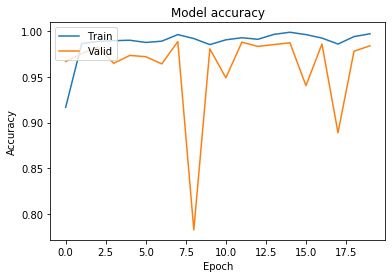

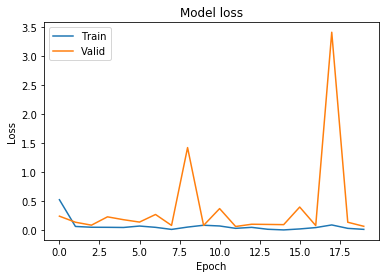

In [32]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

In [33]:
# test_images,test_labels = get_images('./test/')
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)
model.evaluate(X_test,y_test, verbose=1)

1679/1679 [==============================] - 4s 2ms/sample - loss: 0.1065 - acc: 0.9792


[0.10648629832981445, 0.9791542]

In [34]:
model.save('97_9_per_resnet50.h5')